### Download example data from [figshare](https://figshare.com/account/home#/projects/209527) 

In [1]:
# load packages

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nbj

from aicsimageio import AICSImage
from tqdm import tqdm 
from statannotations.Annotator import Annotator

path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

from confocalQuant.qc import return_channel_moments_per_im, get_day_and_time, get_metadata, return_non_unique_indices
from confocalQuant.segmentation import impose_segmentations, get_czi_files
from confocalQuant.data_handling import print_failed_jobs, get_meta_vectors, return_results, load_im_from_memmap, load_im_from_memmap_ravel
from confocalQuant.stats import compute_per_cell_stats
from confocalQuant.plotting import plot_boxplot_by_treatment, plot_boxplot_by_line
from confocalQuant.widgets import toggle_filters, ImageBrowser

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


#### Perform some simple sanity checks

In [48]:
# specify paths
out_parent = '../../new_outs/iNbatch04242024_D54D2_12F4_out/' ## specify path to output data (from out_[..].sbatch runs)
in_parent = '../../new_data/iNbatch04242024_D54D2_12F4/' ## specify raw data inputs (to out_[..].sbatch runs)
files = get_czi_files(in_parent) ## get list of the czi input files

# get per-image metadata
dictionaries = [get_metadata(in_parent+x) for x in files[:105]]
df = pd.DataFrame(dictionaries)

# check that necessary parameters are consistent between images
print('The following metadata variables are NOT consistent across images:')
temp = return_non_unique_indices(df)

The following metadata variables are NOT consistent across images:
SizeZ
AcquisitionDateAndTime
LaserEnableTime


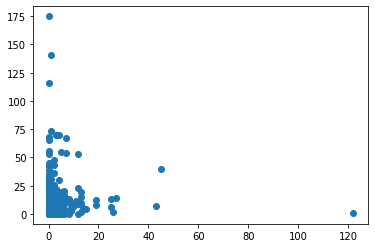

In [50]:
# check for channel leakage
img = AICSImage(in_parent + files[10])
index = np.random.randint(0,len(img.data[0][0].ravel()),1000)
plt.scatter(img.data[0][2].ravel()[index], img.data[0][3].ravel()[index])

In [51]:
# check channel names
img.channel_names

['AF647-T1', 'AF555-T2', 'AF488-T3', 'H3258-T4']

In [59]:
# check image shape 
print('image shape: ' + str(img.data.shape))
print('physical_pixel_sizes: ' + str(img.physical_pixel_sizes))
print('datatype: ' + str(img.dtype))


image shape: (1, 4, 58, 512, 512)
physical_pixel_sizes: PhysicalPixelSizes(Z=1.0, Y=0.62392578125, X=0.62392578125)
datatype: uint8


100%|██████████| 105/105 [00:46<00:00,  2.25it/s]


<Axes: xlabel='time', ylabel='c0'>

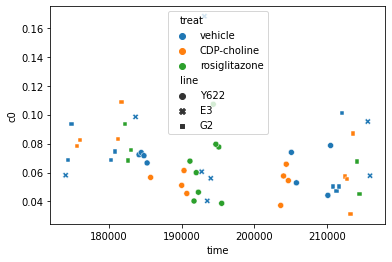

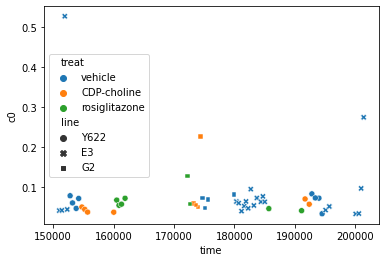

In [104]:
# check for any correlations with imaging day and time; check that conditions were spread out over day and time

day, time = get_day_and_time(df)
mean, std, percent_clipped = return_channel_moments_per_im(files[:105], in_parent, 4, 2**8)
lines, treat = get_meta_vectors(in_parent, files[:105], '_', '_')

means = pd.DataFrame(mean)
means['day'] = day
means['time'] = time
means.columns = ['c0', 'c1', 'c2', 'c3', 'day', 'time']
means['line'] = lines
means['treat'] = treat

sns.scatterplot(data = means[means['day']==21], x = 'time', y = 'c0', hue = 'treat', style = 'line')
plt.figure()
sns.scatterplot(data = means[means['day']==22], x = 'time', y = 'c0', hue = 'treat', style = 'line')

#### Any failed jobs?

In [102]:
print_failed_jobs(out_parent)

# 105 is corrupted

slurm-26142425_1.out
slurm-26142425_2.out
slurm-26142425_3.out
slurm-26142425_5.out
slurm-26142425_7.out
slurm-26142540_105.out
slurm-26142546_105.out
slurm-26142425_105.out


#### Toggle segmentations and discard any poor quality cultures / segmentations 
- the order is arbitrary and depends on the underlying file system. Each image displayed is unidentified and has been assigned a random ID.
- outlines are computed from projected masks, meaning that masks which overlap on the z-axis may be merged in this visualization
- to look at masking in 3D, see next section

In [4]:
I = ImageBrowser('../../new_outs/iNbatch04242024_D54D2_12F4_out/segmentations/')

Output()

In [35]:
print('These are the images you will be discarding: ' + str(I.discard))

These are the images you will be discarding: ['3962164103.png']


#### Toggle images to evaluate segmentations in 3D

In [36]:
segs = impose_segmentations(zi_per_job, Nzi_per_job, all_mat, all_masks, val=.2, files=[2,3]) # val = segmentation outline intensity
toggle_filters(files[0], in_parent, [2,0,1], segs) # select files and channel order / channels to show

100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


#### Load the segmentations & channel intensities

In [37]:
lines, treat = get_meta_vectors(in_parent, files, '_', '_')
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results(out_parent+'out.sbatch', '../.')

#### Remove images as determined above

In [70]:
# toss the images from above
discard = set([x.split('.')[0] for x in I.discard])
keep_indices = np.argwhere([str(x) not in discard for x in randID_per_job.reshape(-1)]).reshape(-1)

In [71]:
# remove failed job 105
keep_indices = keep_indices[[x not in set([105]) for x in keep_indices]]

#### Compute per-cell stats

In [77]:
df = compute_per_cell_stats(keep_indices, zi_per_job, Nzi_per_job, probs, all_masks, all_mat, [None, None, None, None], files, lines, treat, ['dapi', 'neun', '12F4', 'D54D2'])

  0%|          | 0/109 [00:00<?, ?it/s]/home/gridsan/djuna/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 109/109 [01:35<00:00,  1.15it/s]


In [78]:
df.to_csv(out_parent+'quant_continuous.csv')